# Лабораторная работа №3 по дисциплине "Математические методы цифровой обработки сигналов"

# Тема: Алгоритм Гриффина-Лима

#### Выполнил магистрант гр. 9385, Семенов Александр.

## Постановка задачи
**Цель работы:**  продемонстрировать работу алгоритма Гриффина-Лима на речевом сигнале.
1) Средствами ОС записать свой голос с частотой дискретизации $F=8000, 16000 или 22050Гц.

2) Построить амплитудную спектраграмму записанного сигнала.

3) Восстановить записанный речевой сигнал по его спектрограмме алгоритмом Гриффина-Лима.

**Задачи работы:** Исследовать зависимость качества преобразования от следующих параметров:
- Использования фильтра усиления высоких частот и его параметра $\alpha$;
- размерности дискретного преобразования Фурье: $N=512, 1024, 2048, 4096$;
- величины сдвига $h=\frac{N}{4}, \frac{N}{2}, N$;
- числа итераций алгоритма Гриффина-Лима  $i_{max}=16,32,64,128,256$.

Оценка качества сигнала преобразования проводится на основе субъективного сравнения результирующих сигналов и сигнала-этанола.

## Выполнение работы

### 1. Предобработка

Загружаем сигнал и обрезаем тишину по краям

In [11]:
import librosa
import soundfile as sf
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

x, fd = librosa.load('record_Semenov.wav', sr=22050)
x, _ = librosa.effects.trim(x)

Применяем тримминг (удаления отрезков тишины в начале и в конце сигнала) и фильтр усиления высоких частот

In [12]:
alphas = [0.80, 0.90, 0.96, 0.99]
Ns = [2**i for i in range(9, 13)]
i_maxs = [2**i for i in range(4, 9)]
shifts = [2**i for i in range(-2, 1)]

raw, spectrum = x, librosa.stft(x, n_fft=2048, hop_length=512) # Тримминг

alpha, N, h_ratio, i_max = 0.96, 2048, 1/4, 64
h = int(h_ratio*N)
raw = x

x = np.append(x[0], x[1:] - alpha * x[:-1]) # Фильтр усиления высоких частот

### 2. Вычисление спектрограммы

Вычисляем дискретное преобразование Фурье для всех кадров сигнала.

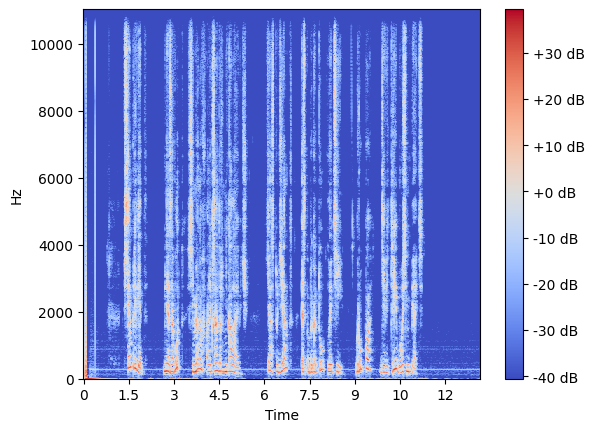

In [13]:
S_db = librosa.amplitude_to_db(np.abs(spectrum))
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, y_axis='linear', x_axis='time', sr=fd)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.show()

### 3. Алгоритм Гриффмана-Лима

In [14]:
X = np.abs(librosa.stft(x, n_fft=N, hop_length=h))
_D = X
for i in range(i_max):
    x_t = librosa.istft(_D, n_fft=N, hop_length=h)
    E = librosa.stft(x_t, n_fft=N, hop_length=h)
    phi = E / np.abs(E)
    _D = X * phi

x_t = librosa.istft(_D, n_fft=N, hop_length=h)
x_ = x_t.real

### 4. Постобработка

Так как на этапе предобработки был использован фильтр усиления высоких частот, для коррекции X используется De-Emphasis

In [15]:
x_ = signal.lfilter([1], [1, -alpha], x_)

### 5. Запись результата и демонстрация рспектрограммы

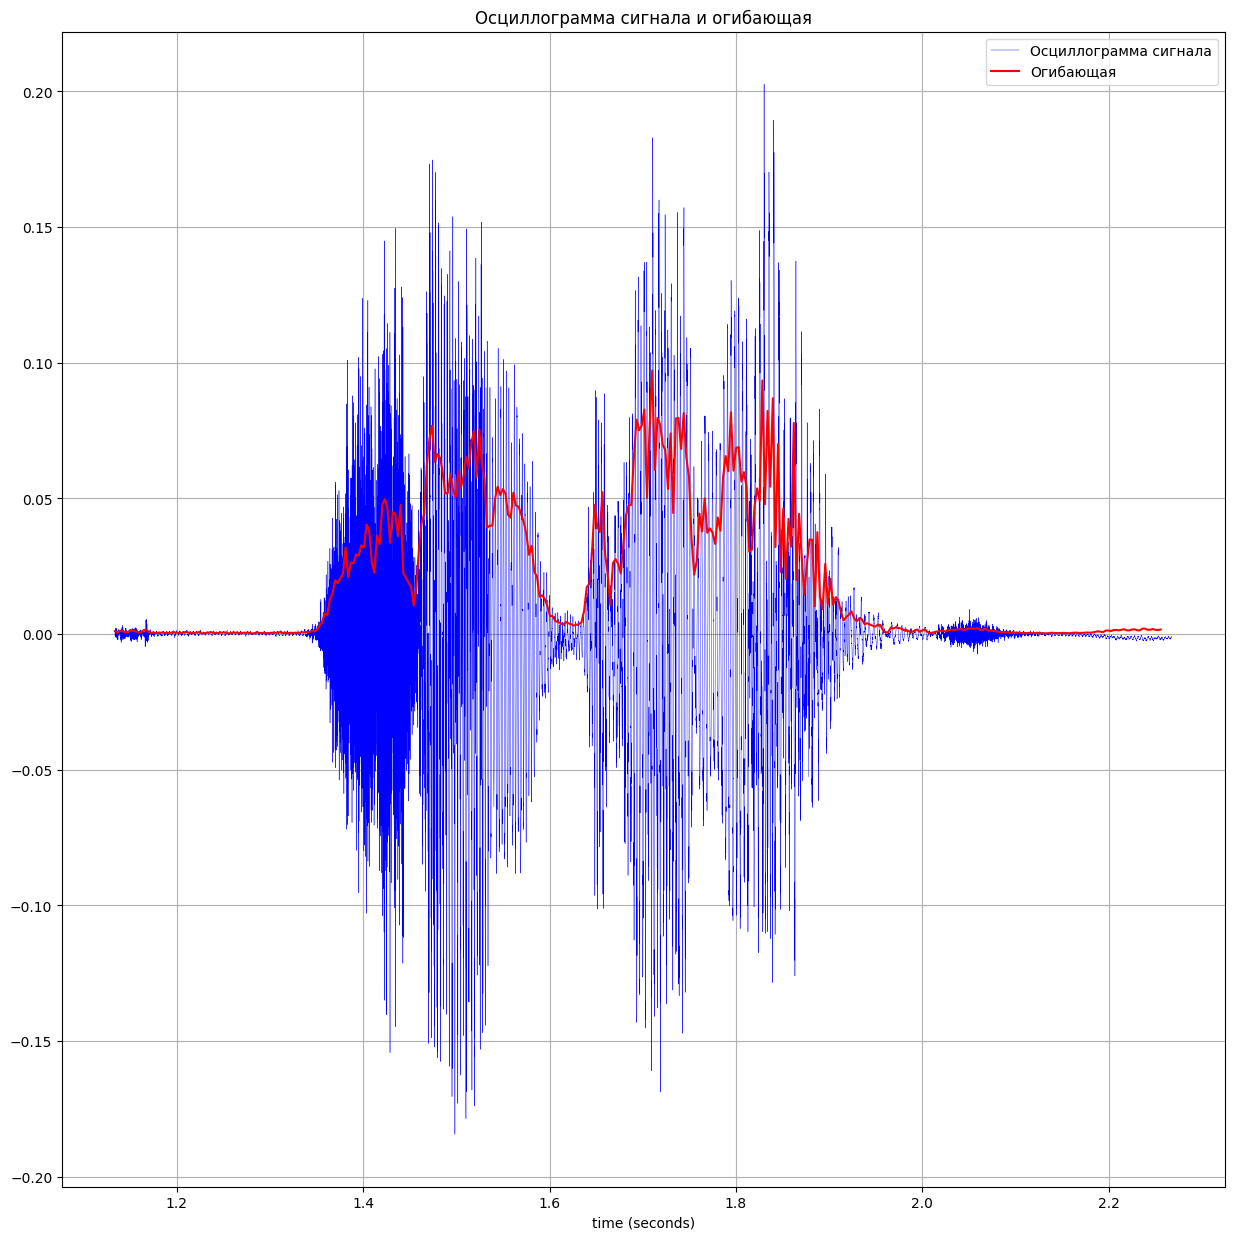

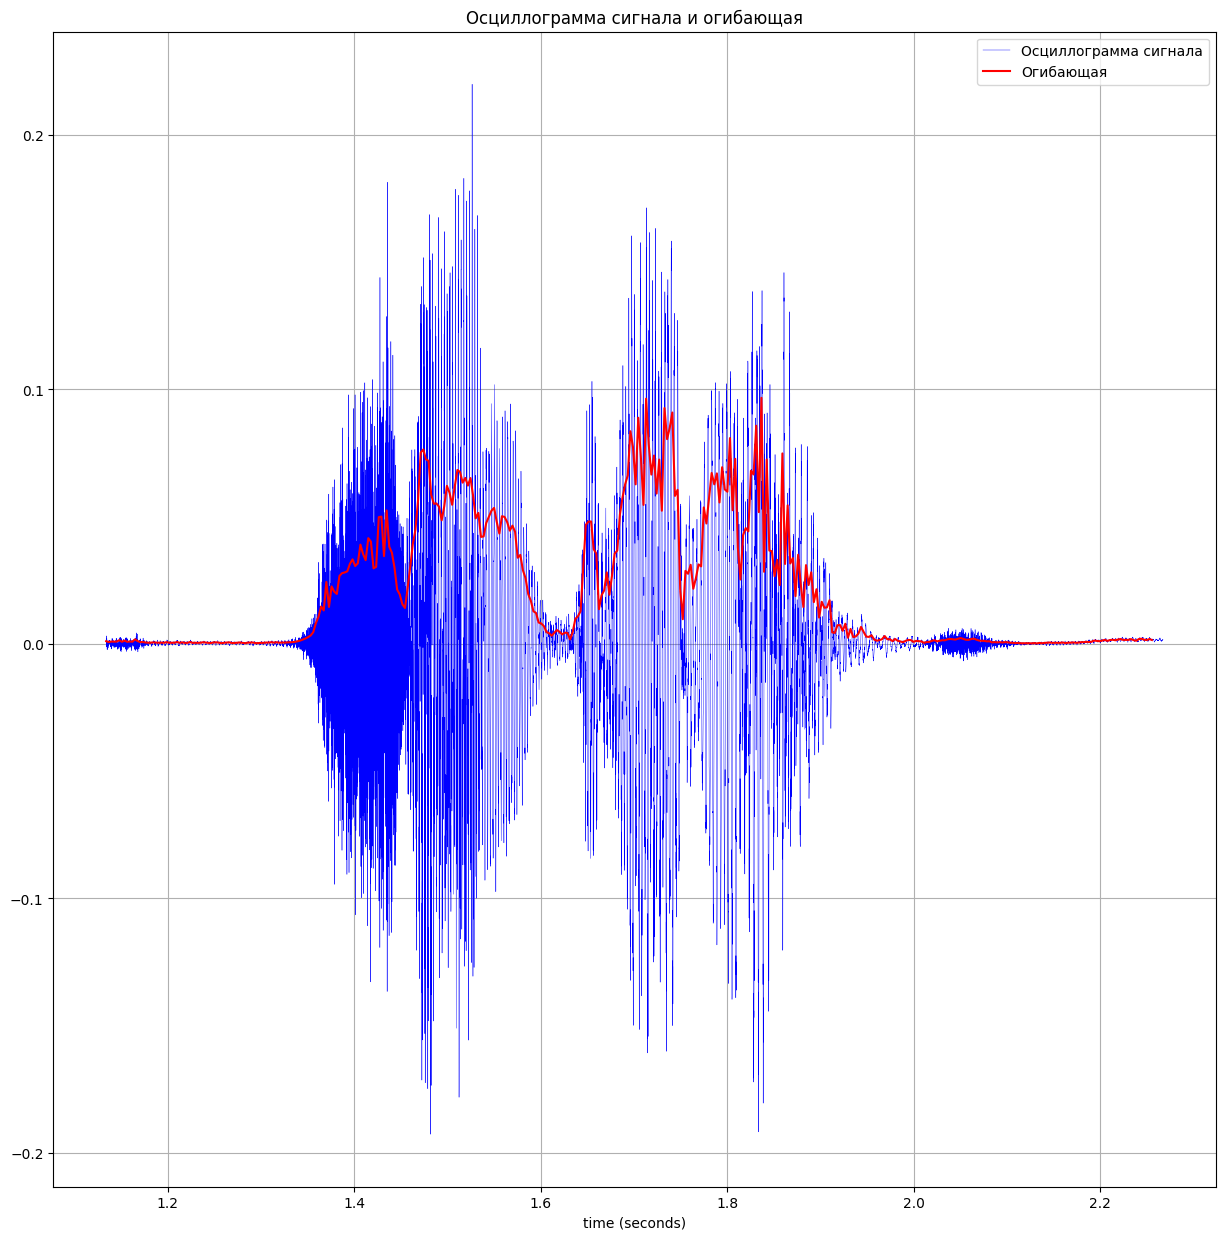

In [20]:
sf.write("GL_result.wav", x_, fd)

def paintGraphics(data, framerate, b, a = 0):
    # a - Правая граница
    # b - Левая граница

    N = b - a # Вычисляем количество точек осциллограммы сигнала
    n = 400 # Задаем количество точек огибающей
    m = int(N/n) # Вычисляем число точек в интервале усреднения
    x = data[a:b] # Строим массив значений осциллограммы сигнала
    y = [np.mean([abs(x[k]) for k in range(m*j, m*(j+1))]) for j in range(n)] # Строим список значений огибающей

    timeSignal = np.arange(a, b) / framerate # Строим массив точек времени для осциллограммы сигнала
    timeOgib = np.arange(a, m*n + a, m) / framerate # Строим массив точек времени для огибающей

    plt.figure(figsize = [15, 15])
    plt.plot(timeSignal, x, color = 'blue',  linewidth = 0.3, label = "Осциллограмма сигнала") # Строим осциллограмму сигнала
    plt.plot(  timeOgib, y, color = 'red',   linewidth = 1.5, label = "Огибающая") # Строим огибающую
    plt.legend()
    plt.xlabel("time (seconds)")
    plt.title("Осциллограмма сигнала и огибающая")
    plt.grid()

    plt.show()

paintGraphics(raw, fd, 50000, 25000)
paintGraphics(x_, fd, 50000, 25000)

__________________________